In [1]:
"""
    VC维的概念：
        2维输入的感知机，VC维=3：
            即能够分类任何三个点（异或是4个点的，所以不行）
        
        支持N维输入的感知机的VC维是N+1
        一些多层感知机的VC维是O(NlogN)
    
    注：VC维对于深度学习的衡量不是很准确
"""
import math
import numpy as np 
import torch 
from torch import nn  
from d2l import torch as d2l

In [4]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0: 4] = np.array([5, 1.2, -3.4, 5.6])

# 随机生成一些噪音
features = np.random.normal(size=(n_train+n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)


In [5]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.4038],
         [-2.3844]]),
 tensor([[ 1.0000e+00,  4.0384e-01,  8.1542e-02,  1.0976e-02,  1.1082e-03,
           8.9504e-05,  6.0241e-06,  3.4754e-07,  1.7544e-08,  7.8719e-10,
           3.1789e-11,  1.1671e-12,  3.9275e-14,  1.2201e-15,  3.5193e-17,
           9.4748e-19,  2.3914e-20,  5.6808e-22,  1.2745e-23,  2.7089e-25],
         [ 1.0000e+00, -2.3844e+00,  2.8426e+00, -2.2593e+00,  1.3467e+00,
          -6.4221e-01,  2.5521e-01, -8.6931e-02,  2.5909e-02, -6.8641e-03,
           1.6367e-03, -3.5476e-04,  7.0490e-05, -1.2929e-05,  2.2019e-06,
          -3.5001e-07,  5.2159e-08, -7.3157e-09,  9.6907e-10, -1.2161e-10]]),
 tensor([  5.2467, -20.1550]))

In [6]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [34]:
def train(train_features, test_features, 
        train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array(
        (train_features, train_labels.reshape(-1, 1)),
        batch_size
    )
    test_iter = d2l.load_array(
        (test_features, test_labels.reshape(-1, 1)),
        batch_size
    )
    updater = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(
        xlabel='epoch',
        ylabel='loss', 
        xlim = [1, num_epochs],
        ylim = [1e-3, 1e2],
        legend = ['train', 'test']
    )
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, test_iter, loss, updater)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(
                epoch + 1, 
                (
                    evaluate_loss(net, train_iter, loss),
                    evaluate_loss(net, test_iter, loss)
                )
            )
    print('weight:', net[0].weight.data.numpy())

KeyboardInterrupt: 

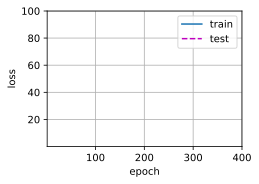

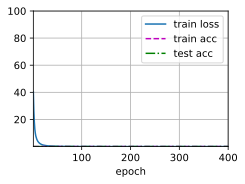

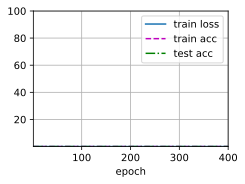

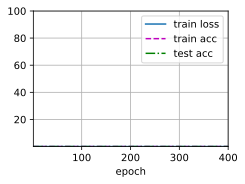

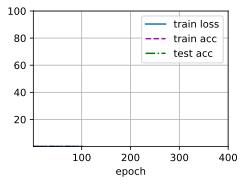

In [35]:
train(
    poly_features[:n_train, :4], 
    poly_features[n_train:, :4], 
    labels[: n_train], 
    labels[n_train:]
)